In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
device = torch.device("cuda")

In [28]:
torch.cuda.is_available()

True

In [29]:
torch.tensor([[1, 2, 3], [1, 2, 3]]).to(device)

tensor([[1, 2, 3],
        [1, 2, 3]], device='cuda:0')

In [30]:
batch_size = 100
train_datasets = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=False)
test_datasets = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=False)
train_data = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
test_data = DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

In [31]:
description = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

frog


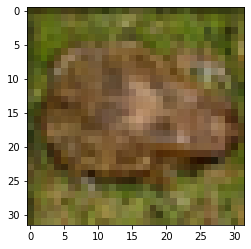

In [32]:
images, labels = next(iter(test_data))
plt.imshow(images[0].permute(1, 2, 0))
print(description[labels[0].item()])

In [33]:
def caculate_infos(size,parameters):
    return (parameters[1],((size-parameters[2]+2*parameters[4])/parameters[3])+1)
caculate_infos(16,(256,512,3,1,1))


(512, 16.0)

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 64,16*16
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 128,8*8
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 256,4*4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # 512,2*2
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        ) # 1024,2*2
        self.fc1 = nn.Sequential(
            nn.Linear(1024*2*2, 1024),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.out = nn.Linear(512,10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x

net = CNN()
net = net.to(device)

In [41]:

def train(epochs=1, learning_rate=0.001):
    max_record = 0.14 # 手动修改
    net.load_state_dict(torch.load('CNN-CIFAR10.pkl'))
    loss_function = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        net.train()
        for i, (images, labels) in enumerate(train_data):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_function(outputs, labels)
            optimizer = optim.Adam(net.parameters(), lr=learning_rate)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total = 10000
        correct = 0
        net.eval()
        for i, (images, labels) in enumerate(test_data):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.tolist()
            outputs = net(images)
            predict = torch.max(outputs,1).indices.tolist()
            total += len(predict)
            for i in range(len(predict)):
                if predict[i] == labels[i]:
                    correct += 1
        
        if correct/total>max_record:
            max_record = correct/total
            torch.save(net.state_dict(),'CNN-CIFAR10.pkl')
            print(f"epoch {epoch}: {max_record} 已保存")
        else:
            print(f"epoch {epoch}: {correct/total}")
            
train(30, learning_rate=0.001)

epoch 0: 0.20255 已保存
epoch 1: 0.17775
epoch 2: 0.1952
epoch 3: 0.172
epoch 4: 0.1209
epoch 5: 0.20755 已保存
epoch 6: 0.22175 已保存
epoch 7: 0.2172
epoch 8: 0.07925
epoch 9: 0.0977
epoch 10: 0.22685 已保存
epoch 11: 0.25035 已保存
epoch 12: 0.17775
epoch 13: 0.26495 已保存
epoch 14: 0.08995
epoch 15: 0.28835 已保存
epoch 16: 0.23955
epoch 17: 0.2735
epoch 18: 0.25425
epoch 19: 0.2728
epoch 20: 0.26225
epoch 21: 0.2811
epoch 22: 0.31095 已保存
epoch 23: 0.2883
epoch 24: 0.2721
epoch 25: 0.32545 已保存
epoch 26: 0.26675
epoch 27: 0.27205
epoch 28: 0.33595 已保存
epoch 29: 0.3157


In [42]:
total = 10000
correct = 0
for i, (images, labels) in enumerate(test_data):
    images = images.to(device)
    labels = labels.tolist()
    outputs = net(images)
    predict = torch.max(outputs,1).indices.tolist()
    total += len(predict)
    for i in range(len(predict)):
        if predict[i] == labels[i]:
            correct += 1
print(f" {correct/total*100}%")

 31.569999999999997%


In [152]:
len(test_datasets)

10000